# Review
Hi, my name is Dmitry and I will be reviewing your project.

You can find my comments in colored markdown cells:

<div class="alert alert-success">
    If everything is done succesfully.
</div>

<div class="alert alert-warning">
    If I have some (optional) suggestions, or questions to think about, or general comments.
</div>

<div class="alert alert-danger">
    If a section requires some corrections. Work can't be accepted with red comments.
</div>

Please don't remove reviewer's comments! All iterations of one project are done by the same reviewer, and if you remove comments from the previous iteration, it makes it hard to understand what changed and what problems there were. Thankfully, as I recall, your project didn't have any problems, apart from a bit unclear conclusions, and you fixed that. I hope you don't mind if I don't reproduce all the comments praising your work :) The project is accepted. Good luck on the next sprint!

# Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

# Init

In [5]:
%%capture
%%bash

pip install transformers -qq
pip install contractions
pip install emoji
pip install catboost -q
python -m spacy download en -q
python -m spacy download en_core_web_sm -q
pip install gdown -q

In [6]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import *
import sklearn.metrics as metrics
import seaborn as sns
from tqdm.auto import tqdm
import string
import gc
import nltk
nltk.download('stopwords')  
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import spacy

import contractions
import emoji
from html import unescape
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler, random_split
# import torchtext
from tqdm.notebook import tqdm
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import get_linear_schedule_with_warmup
import transformers
from transformers import BertTokenizer, BertConfig, BertModel, AdamW, get_linear_schedule_with_warmup
import time
import h5py
import gensim
import gensim.downloader
from collections import defaultdict
import random
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def setup_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

random_state=42
setup_seed(random_state)

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

In [9]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [10]:
%%capture

!pip install ipython-autotime
 
%load_ext autotime

time: 285 µs


In [7]:
#missing value ratio
def missing_values(df):
    df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
    df_nulls.columns = ["type","count","missing_ratio"]
    df_nulls=df_nulls[df_nulls["count"]>0]
    df_nulls.sort_values(by="missing_ratio", ascending=False)
    return df_nulls

#outliers by 3 sigma rule
def outlier(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return len(outliers)

# full description statistics 
def describe_full(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    data_describe['outliers']=[outlier(df_numeric[col]) for col in df_numeric.columns]
    data_describe['kurtosis']=df_numeric.kurtosis()
    return data_describe

time: 23.9 ms


In [ ]:
def display_classification_report(y_true, y_pred):
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T)
    
def plot_roc(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        if not ax: fig, ax = plt.subplots(1, 1)
        fpr, tpr, thresholds = roc_curve(y_test, preds)
        ax.plot([0, 1], [0, 1],'r--')
        ax.plot(fpr, tpr, lw=2, label=label)
        ax.legend(loc='lower right')
        ax.set_title(
             'ROC curve\n'
            f""" AP: {average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {auc(fpr, tpr):.2}')
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.annotate(f'AUC: {auc(fpr, tpr):.2}', xy=(.43, .025))
        ax.legend()
        ax.grid()
        return ax
    

def plot_pr(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        precision, recall, thresholds = precision_recall_curve(y_test, preds)
        if not ax: fig, ax = plt.subplots()
        ax.plot([0, 1], [1, 0],'r--')    
        ax.plot(recall, precision, lw=2, label=label)
        ax.legend()
        ax.set_title(
            'Precision-recall curve\n'
            f""" AP: {average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {auc(recall, precision):.2}'
        )
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.legend()
        ax.grid()
        return ax

time: 25.8 ms


In [ ]:
def to_h5(in_object, outfile):
  with h5py.File('data.h5', 'w') as h5f:
    h5f.create_dataset('dataset_1', data=in_object)

def from_h5(in_file):
  with h5py.File('data.h5','r') as h5f:
     return h5f['dataset_1'][:]

time: 2.79 ms


# Load Data

In [ ]:
df_reviews = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

time: 10.8 s


In [ ]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


time: 40.3 ms


In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [ ]:
df_reviews[df_reviews["average_rating"].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


time: 30.8 ms


couple records are missed, it's not big deal, let's remove it

In [ ]:
df_reviews = df_reviews[~df_reviews["average_rating"].isna()]

time: 11.2 ms


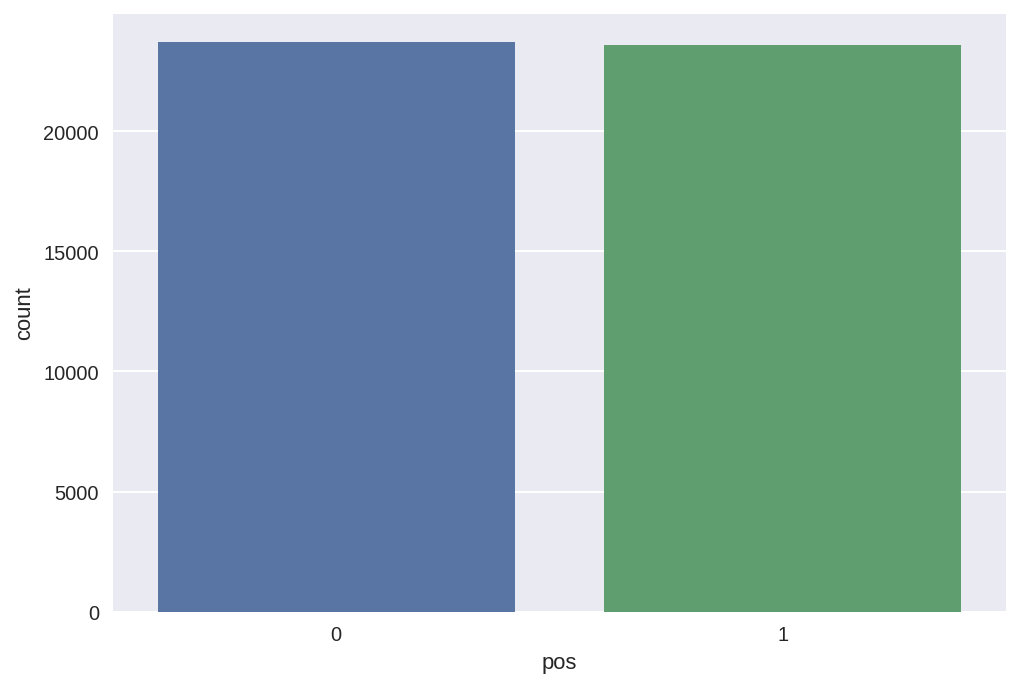

time: 234 ms


In [ ]:
sns.countplot(df_reviews["pos"])

as we see, in our case dataset is pretty balanced

In [ ]:
describe_full(df_reviews)

,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew,outliers,kurtosis
start_year,47329.0,1989.630882,19.600702,1894.0,1982.0,1998.0,2004.0,2010.0,int64,0.0,107,-1.566086,555,1.907585
is_adult,47329.0,0.001733,0.041588,0.0,0.0,0.0,0.0,1.0,int64,0.0,2,23.962910,82,572.245241
average_rating,47329.0,5.998278,1.494289,1.4,5.1,6.3,7.1,9.7,float64,0.0,83,-0.662190,76,0.005910
votes,47329.0,25562.917323,83670.039163,9.0,827.0,3197.0,13974.0,1739448.0,Int64,0.0,3748,7.813169,913,83.271791
rating,47329.0,5.484439,3.473083,1.0,2.0,4.0,9.0,10.0,int64,0.0,8,-0.002823,0,-1.632479
pos,47329.0,0.498933,0.500004,0.0,0.0,0.0,1.0,1.0,int64,0.0,2,0.004268,0,-2.000066
idx,47329.0,6279.826808,3605.724280,0.0,3162.0,6300.0,9412.0,12499.0,int64,0.0,12500,-0.010743,0,-1.201795


time: 626 ms


# EDA

Let's check the number of movies and reviews over years.

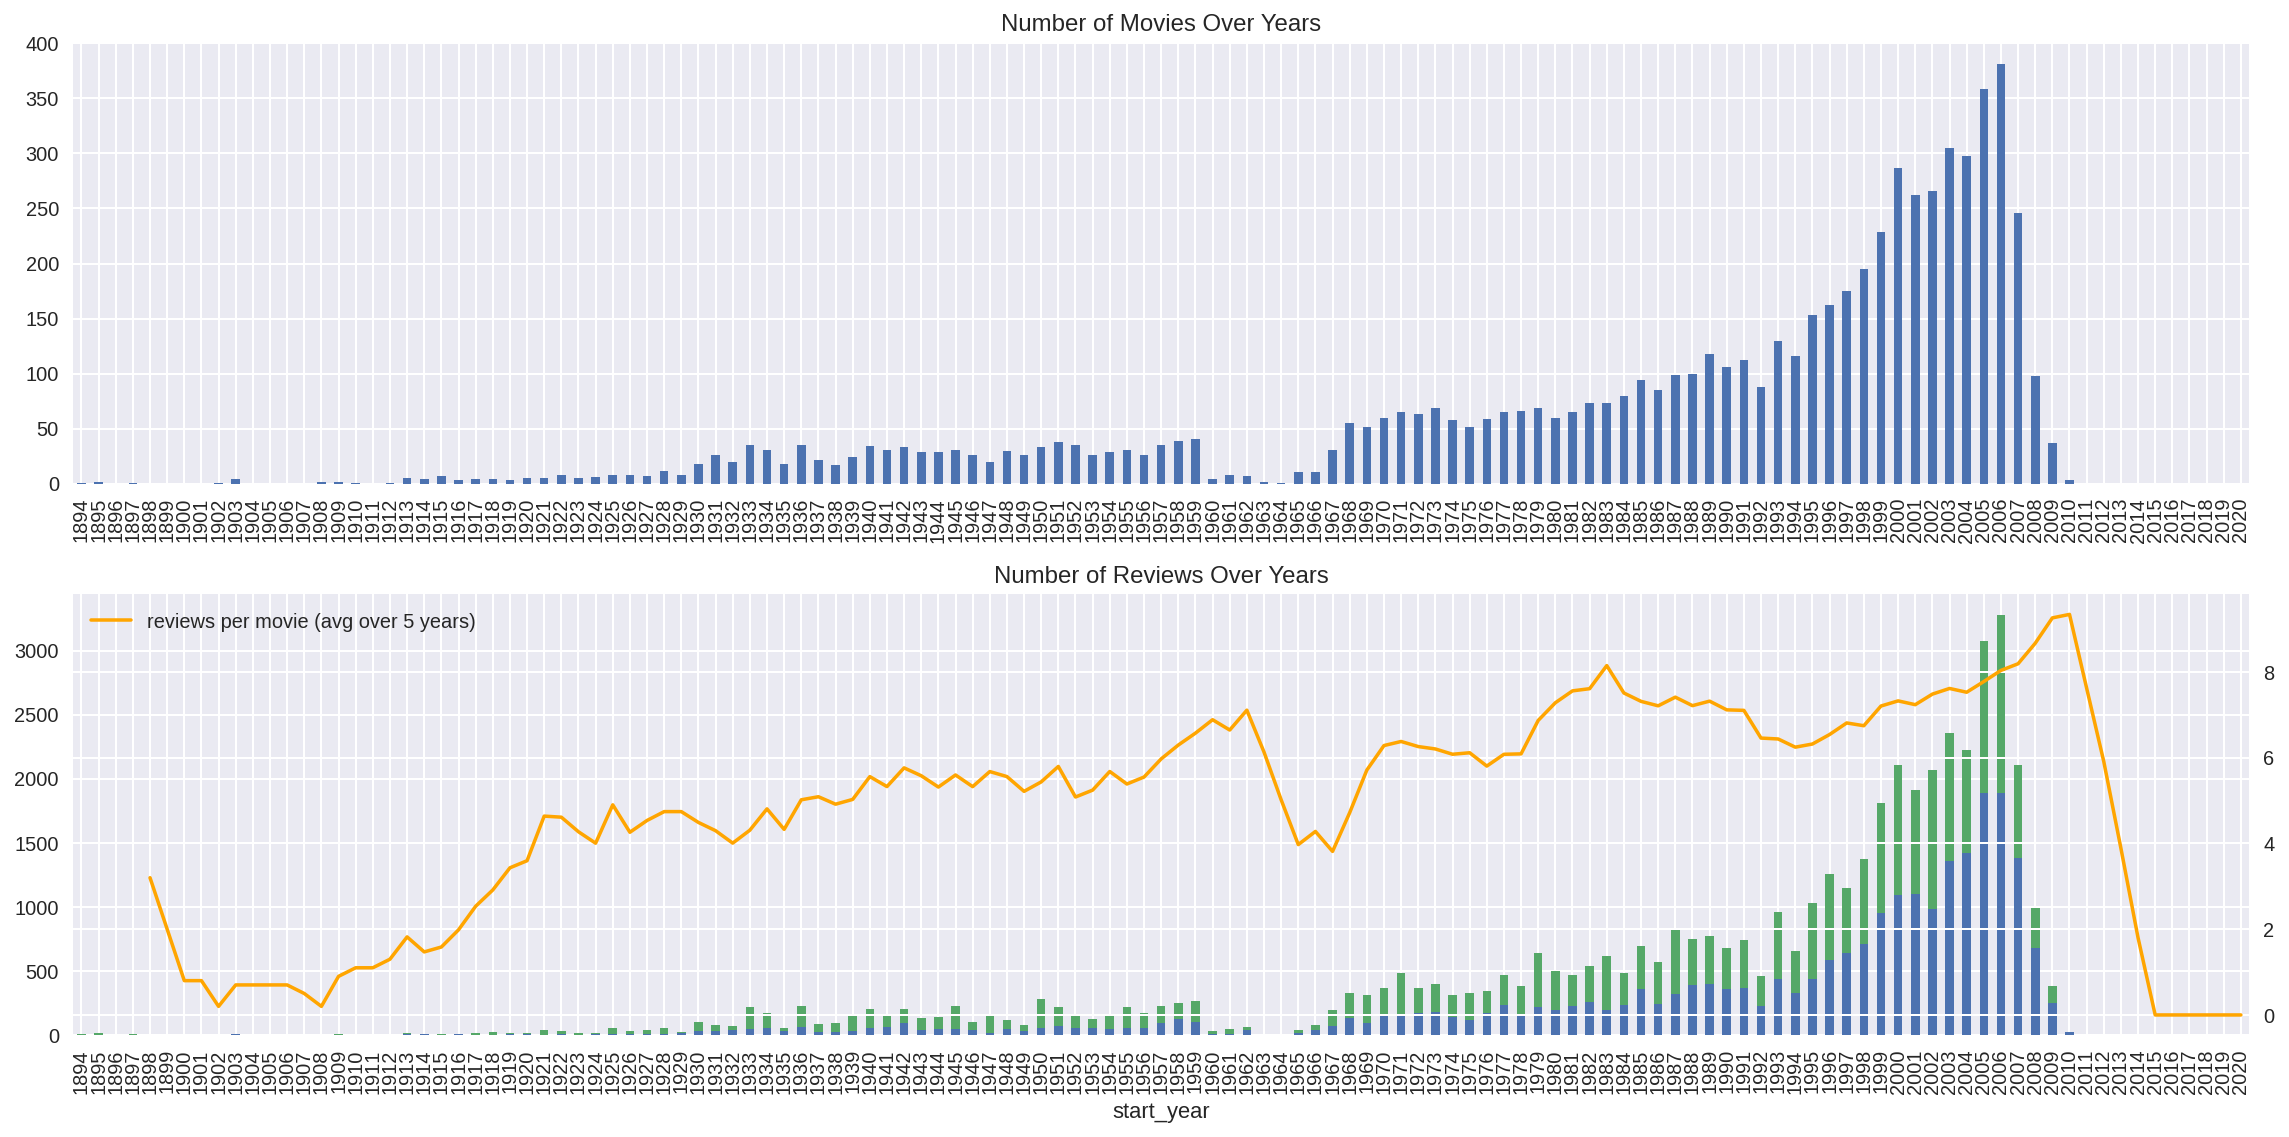

time: 4.06 s


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

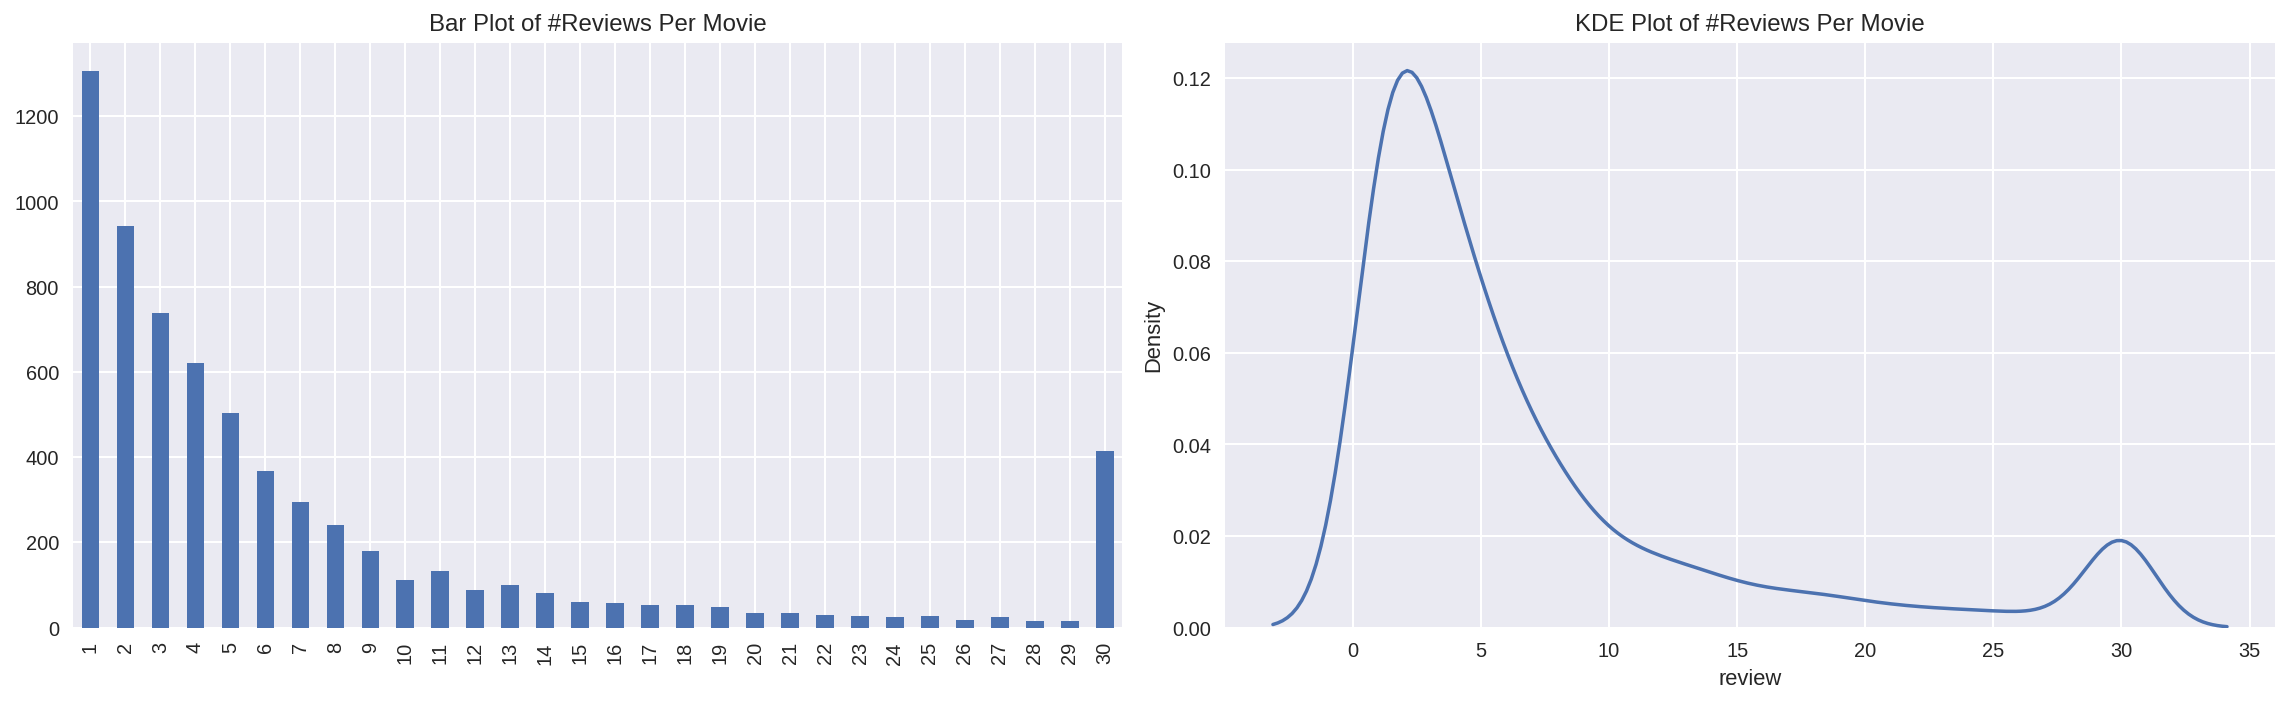

time: 952 ms


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [ ]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

time: 6.83 ms


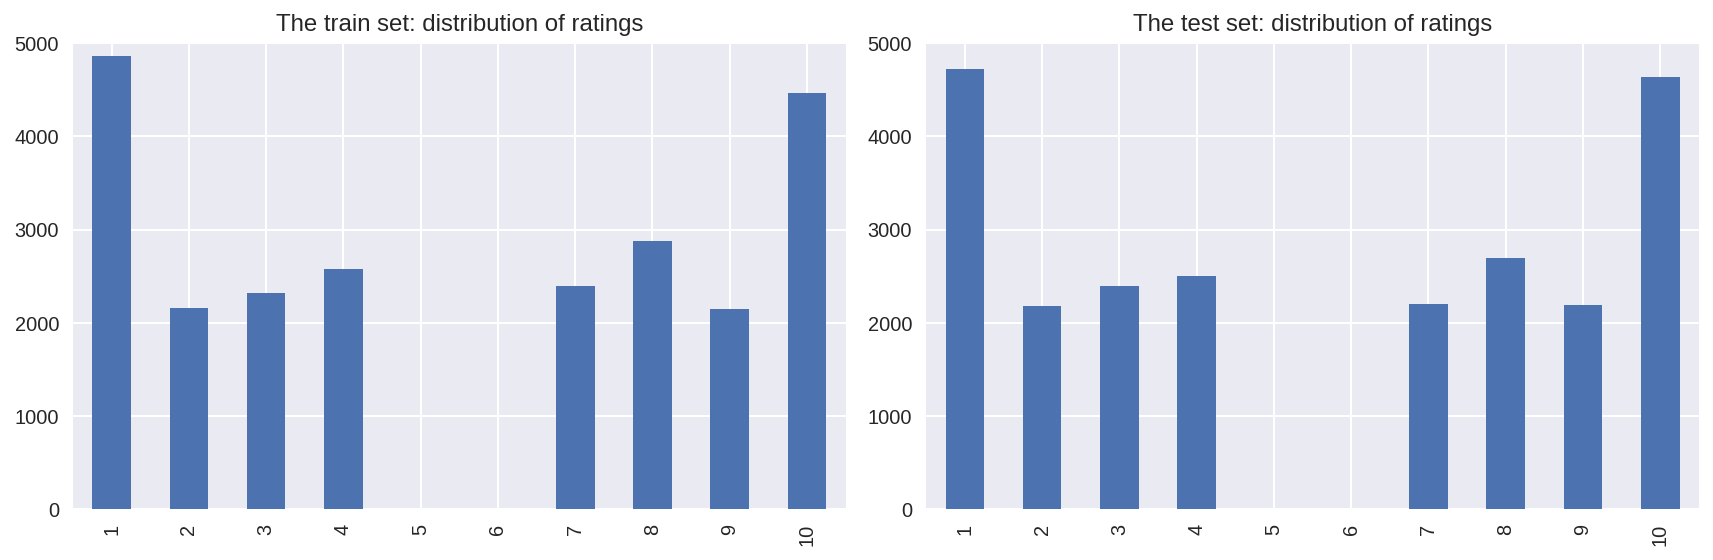

time: 519 ms


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

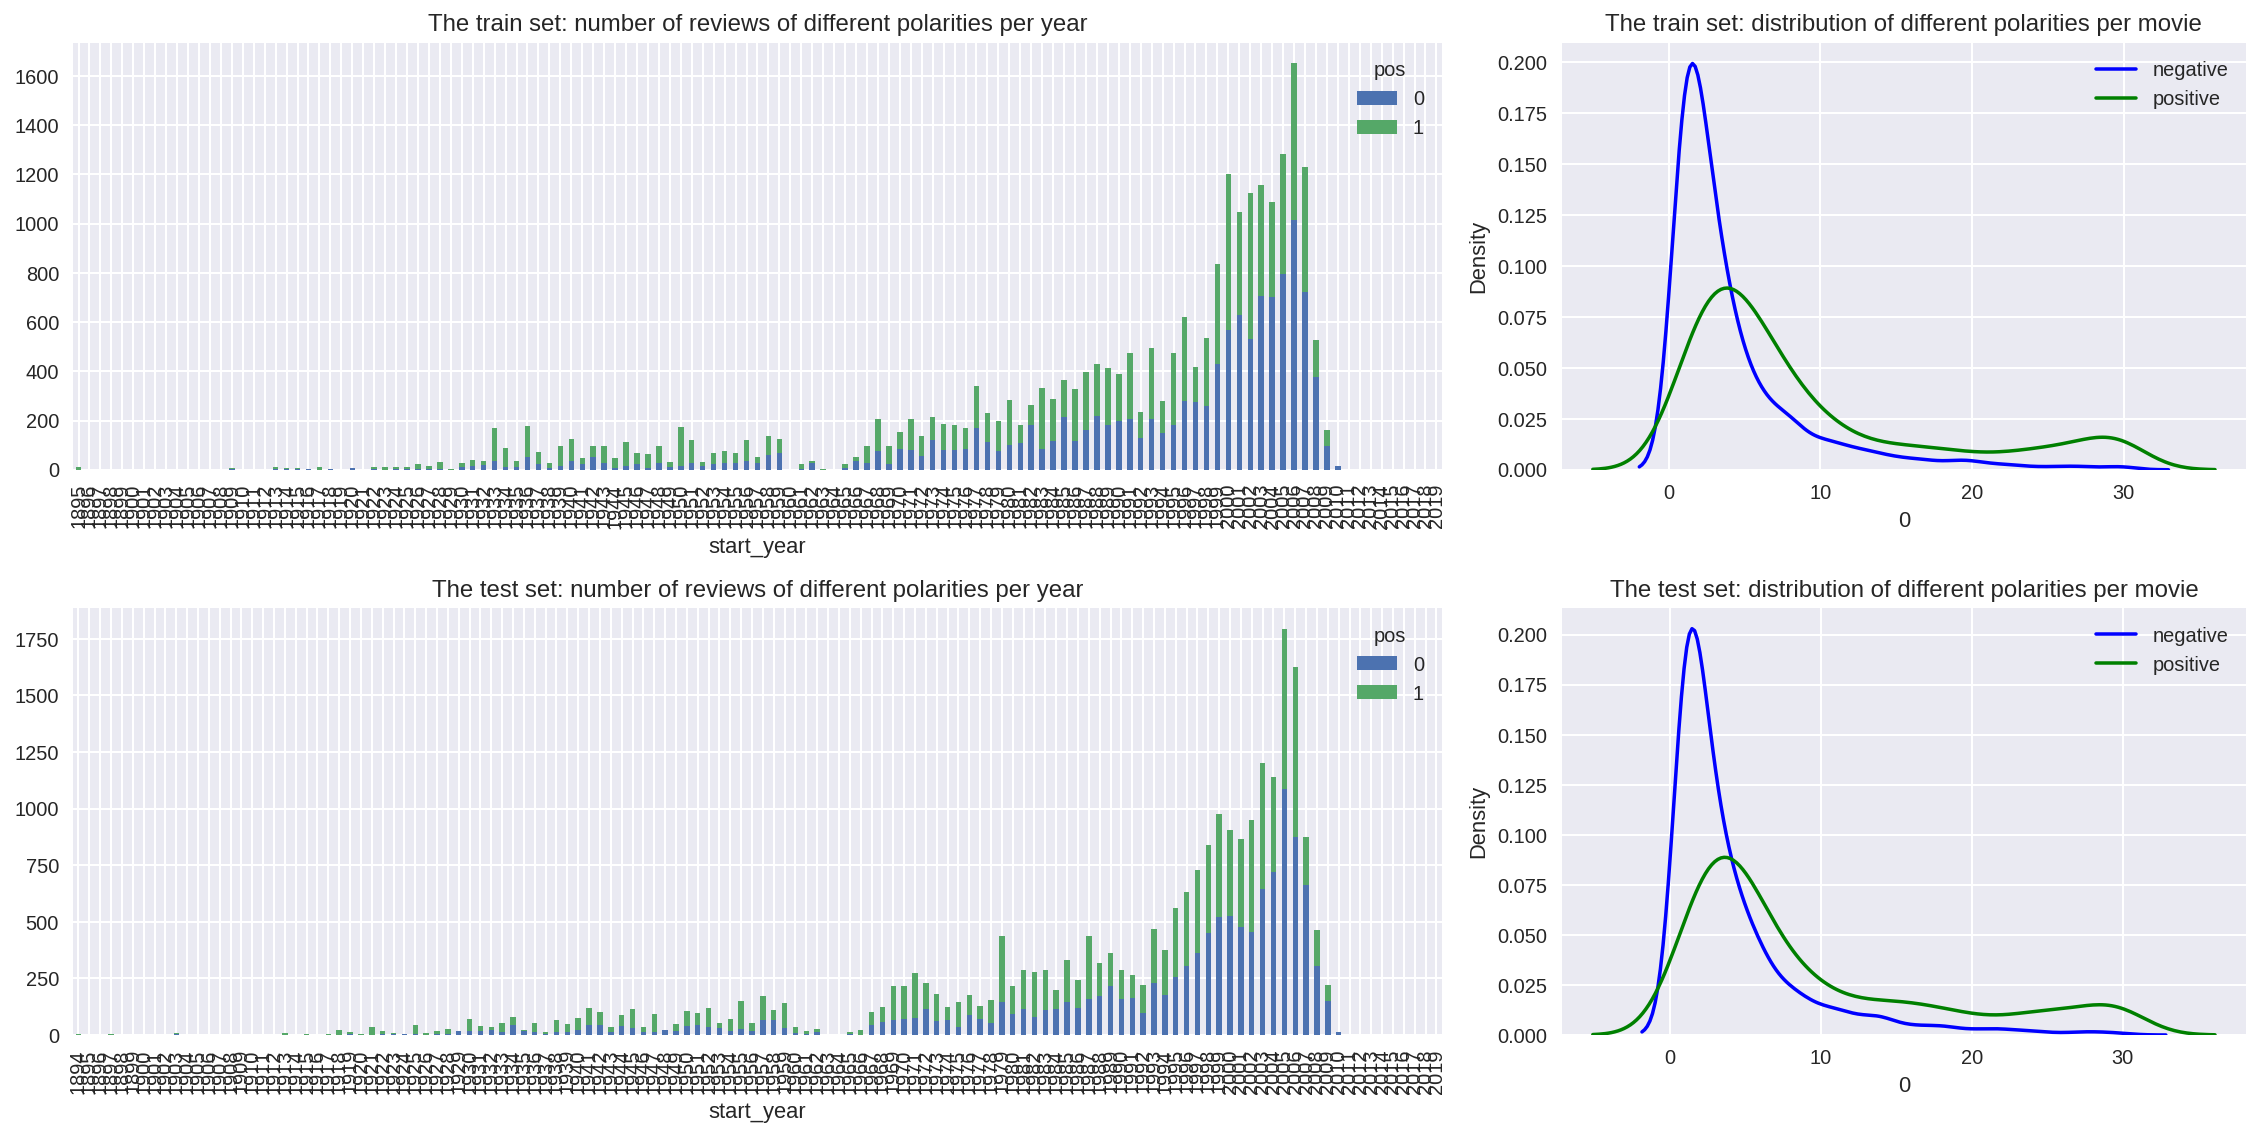

time: 6.76 s


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

# Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [ ]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

time: 123 ms


# Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [ ]:
def clean_text(sentence):
  return " ".join(t for t in sentence.split() if not t.isdigit() and t.isalpha())


def clean_column(in_data:pd.Series) -> np.ndarray:
  df = in_data.str.strip().str.lower().str.strip(string.punctuation+" ")
  df = df.str.replace("[^a-zA-Z]", " ")
  df = np.vectorize(contractions.fix)(df)
  df = np.vectorize(emoji.demojize)(df)
  df = np.vectorize(unescape)(df)
  df = np.vectorize(clean_text)(df)
  return df

In [11]:
import os
if os.path.exists('/content/drive/My Drive/imdb.csv.zip'):
  df_reviews = pd.read_csv('/content/drive/My Drive/imdb.csv.zip')
else:
  df_reviews['review_norm'] = clean_column(df_reviews['review'])
  df_reviews.to_csv("imdb.csv", index=False)
  try:
    !zip imdb.csv.zip imdb.csv
    !cp imdb.csv.zip /content/drive/My\ Drive/
  except:
    pass

df_reviews['review_norm'].head(2)

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
Name: review_norm, dtype: object

time: 2.13 s


# Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [12]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)
time: 58.4 ms


In [13]:
target = "pos"
features = list(set(df_reviews_train.columns)-set([target])-set(["review"]))

time: 1.66 ms


In [ ]:
X_train, X_test, y_train, y_test =  df_reviews_train[features], df_reviews_test[features], train_target, test_target

>also in real case need split X_train to train/valid sets

# Model 0 - Constant

In [ ]:
model = DummyClassifier().fit(X_train, y_train)
y_pred = model.predict(X_test)
display_classification_report(y_test, y_pred)

,precision,recall,f1-score,support
0,0.504395,0.500805,0.502593,11803.000000
1,0.501270,0.504859,0.503058,11730.000000
accuracy,0.502826,0.502826,0.502826,0.502826
macro avg,0.502832,0.502832,0.502826,23533.000000
weighted avg,0.502837,0.502826,0.502825,23533.000000


time: 62.3 ms


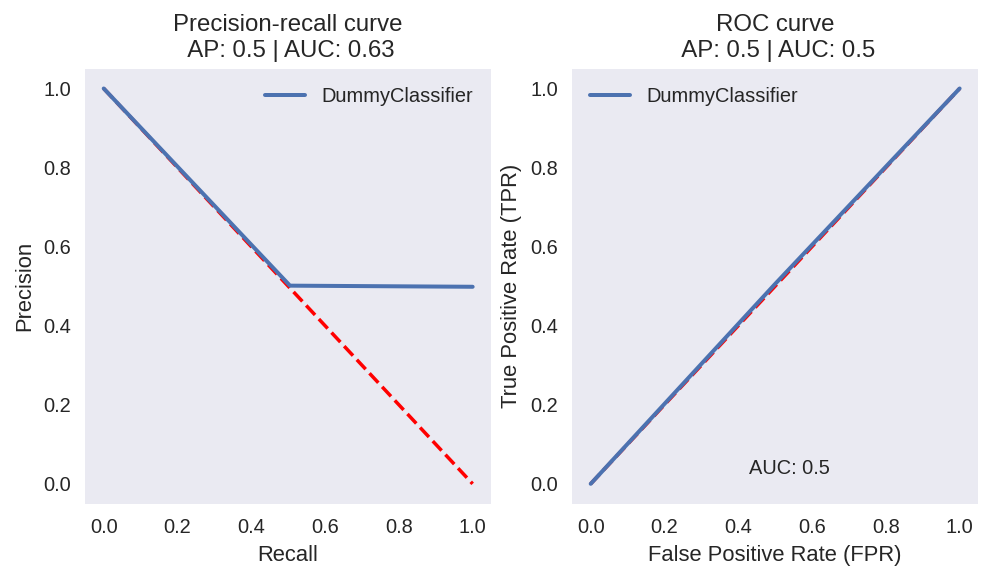

time: 421 ms


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
_ = plot_pr(y_test, y_pred, ax=ax[0],label="DummyClassifier")
_ = plot_roc(y_test, y_pred, ax=ax[1],label="DummyClassifier")

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


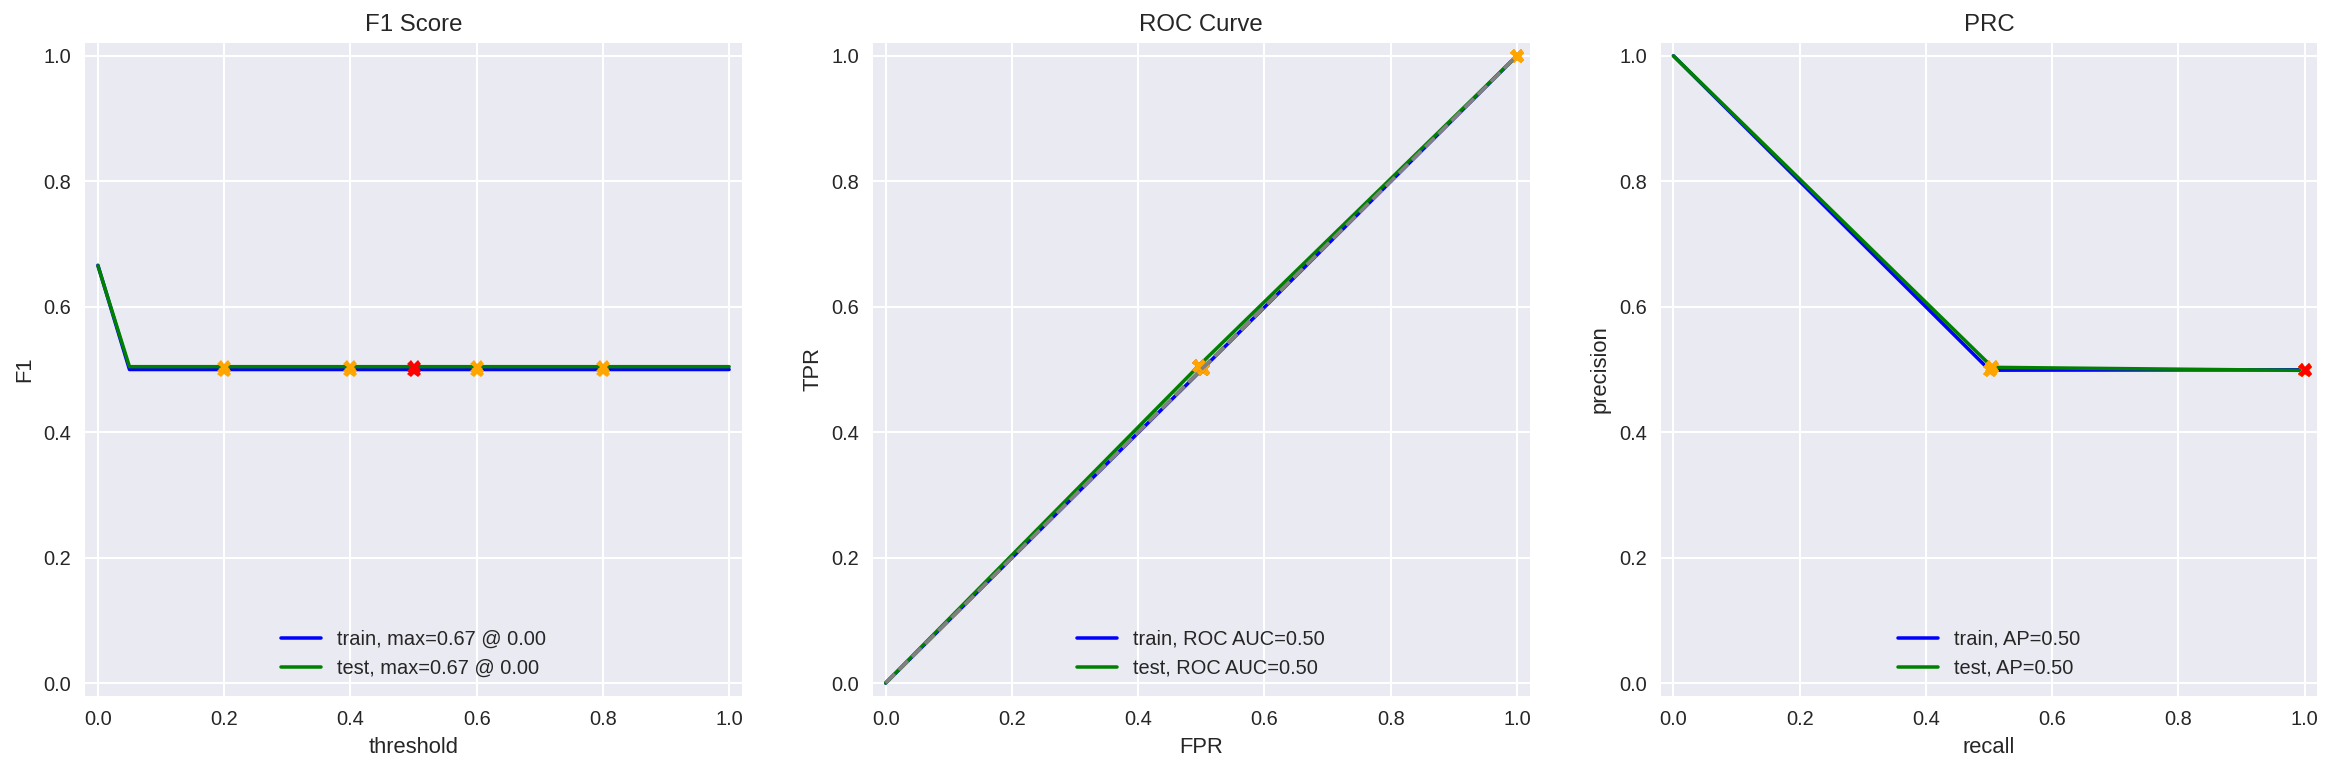

time: 1.26 s


In [ ]:
model = DummyClassifier().fit(X_train, y_train)
evaluate_model(model, X_train, y_train, X_test, y_test)

just random guessing 50/50

# Model 1 BoW + Naive Bayes

let's try classic approach: CountVectorizer(BoW)+ Naive Bayes

In [ ]:
vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(df_reviews_train['review_norm'].values)
classifier = MultinomialNB()
targets = df_reviews_train['pos'].values
classifier = classifier.fit(counts, targets)

time: 3.67 s


,precision,recall,f1-score,support
0,0.778028,0.877828,0.824920,11803.000000
1,0.858849,0.747997,0.799599,11730.000000
accuracy,0.813114,0.813114,0.813114,0.813114
macro avg,0.818438,0.812912,0.812260,23533.000000
weighted avg,0.818313,0.813114,0.812299,23533.000000


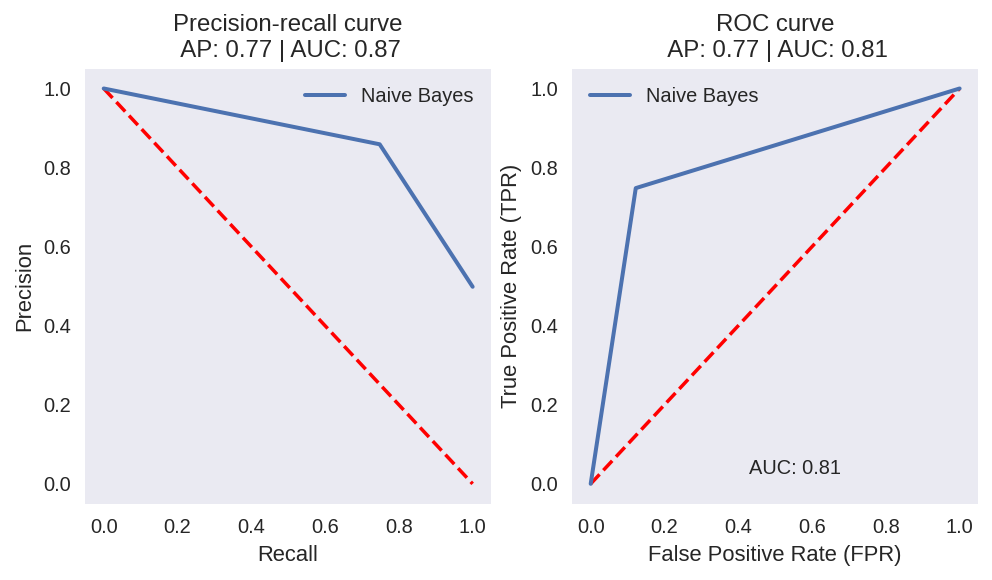

time: 4.09 s


In [ ]:
y_pred = classifier.predict(vectorizer.transform(df_reviews_test['review_norm'].values))
display_classification_report(y_test, y_pred)
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
_ = plot_pr(y_test, y_pred, ax=ax[0],label="Naive Bayes")
_ = plot_roc(y_test, y_pred, ax=ax[1],label="Naive Bayes")

          train  test
Accuracy   0.90  0.81
F1         0.89  0.80
APS        0.96  0.87
ROC AUC    0.96  0.89


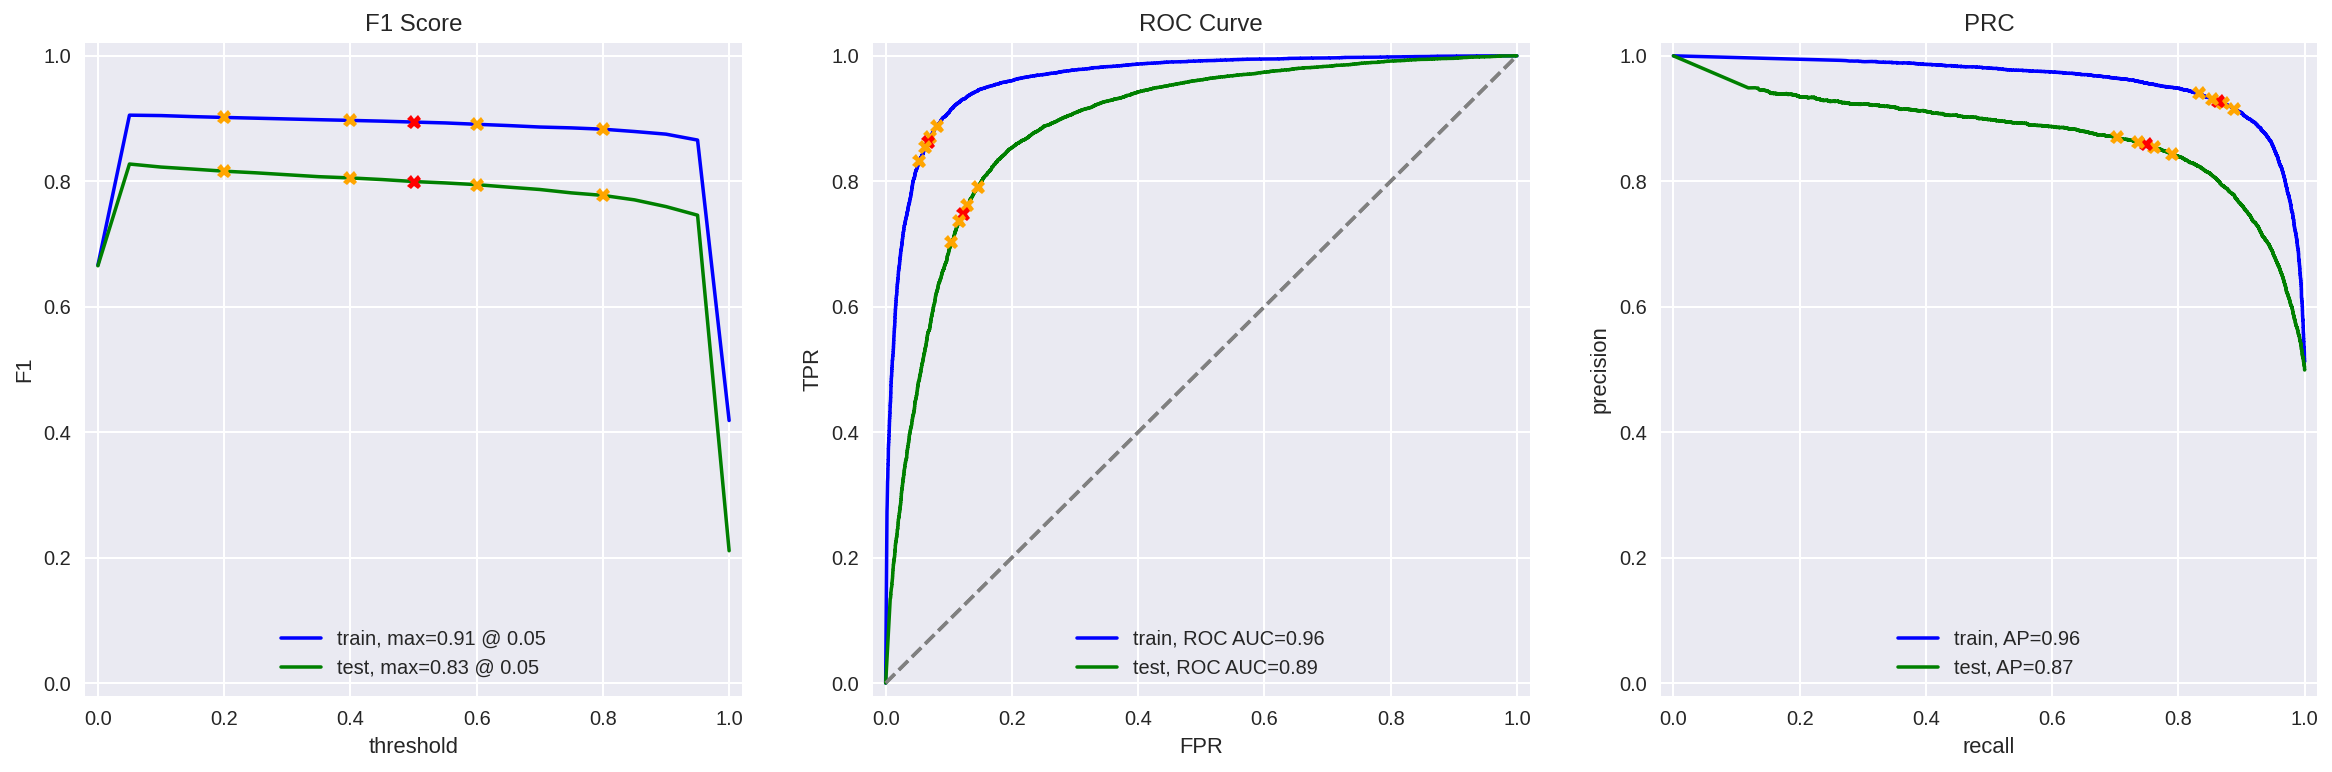

time: 4.97 s


In [ ]:
evaluate_model(classifier, counts, targets, vectorizer.transform(df_reviews_test['review_norm'].values), y_test)

as we see, for a reason classic Naive Bayes was popular, without any problem we got pretty good result, which is overfitted but it's not a problem for that case

In [ ]:
del classifier, counts, targets

time: 1.67 ms


# Model 2 - NLTK, TF-IDF and LR

### TF-IDF

let's try insted of counts, to use more sophisticated tf-idf + simplest neural network;) -> Logistic Regression, but for simplicity I am not going to use cross validation as it was on the previous model

also I use ngram (for rid of typos)

In [ ]:
tfv=TfidfVectorizer(min_df=0, max_features=10_000, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=(1,1),
                            use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english")   
X_train_tfv = tfv.fit_transform(df_reviews_train['review_norm'].values)

time: 2.87 s


,precision,recall,f1-score,support
0,0.885254,0.880454,0.882848,11803.000000
1,0.880363,0.885166,0.882758,11730.000000
accuracy,0.882803,0.882803,0.882803,0.882803
macro avg,0.882809,0.882810,0.882803,23533.000000
weighted avg,0.882816,0.882803,0.882803,23533.000000


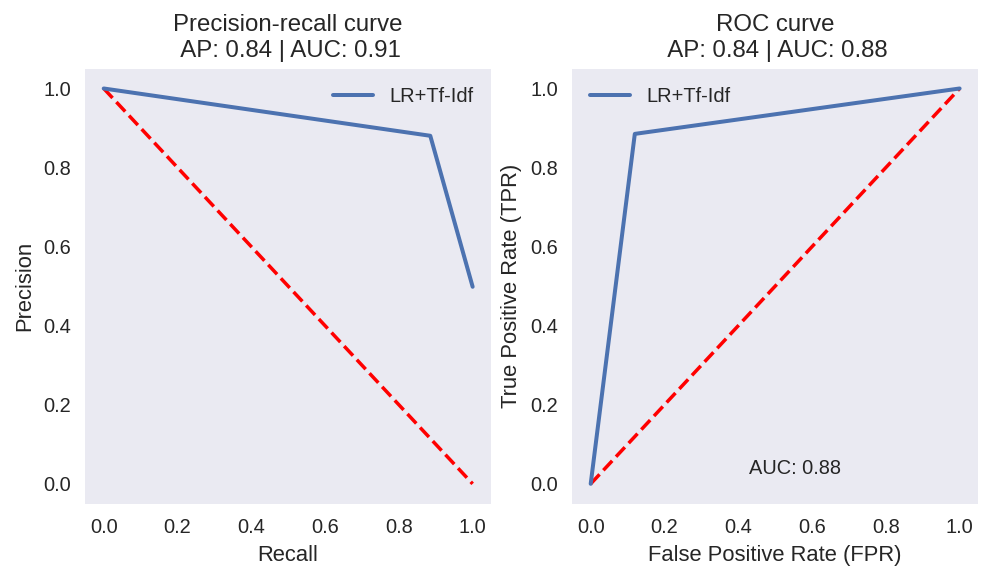

time: 3.67 s


In [ ]:
lr = LogisticRegression().fit(X_train_tfv, y_train)
y_pred = lr.predict(tfv.transform(df_reviews_test['review_norm'].values))
display_classification_report(y_test, y_pred)
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
_ = plot_pr(y_test, y_pred, ax=ax[0],label="LR+Tf-Idf")
_ = plot_roc(y_test, y_pred, ax=ax[1],label="LR+Tf-Idf")

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


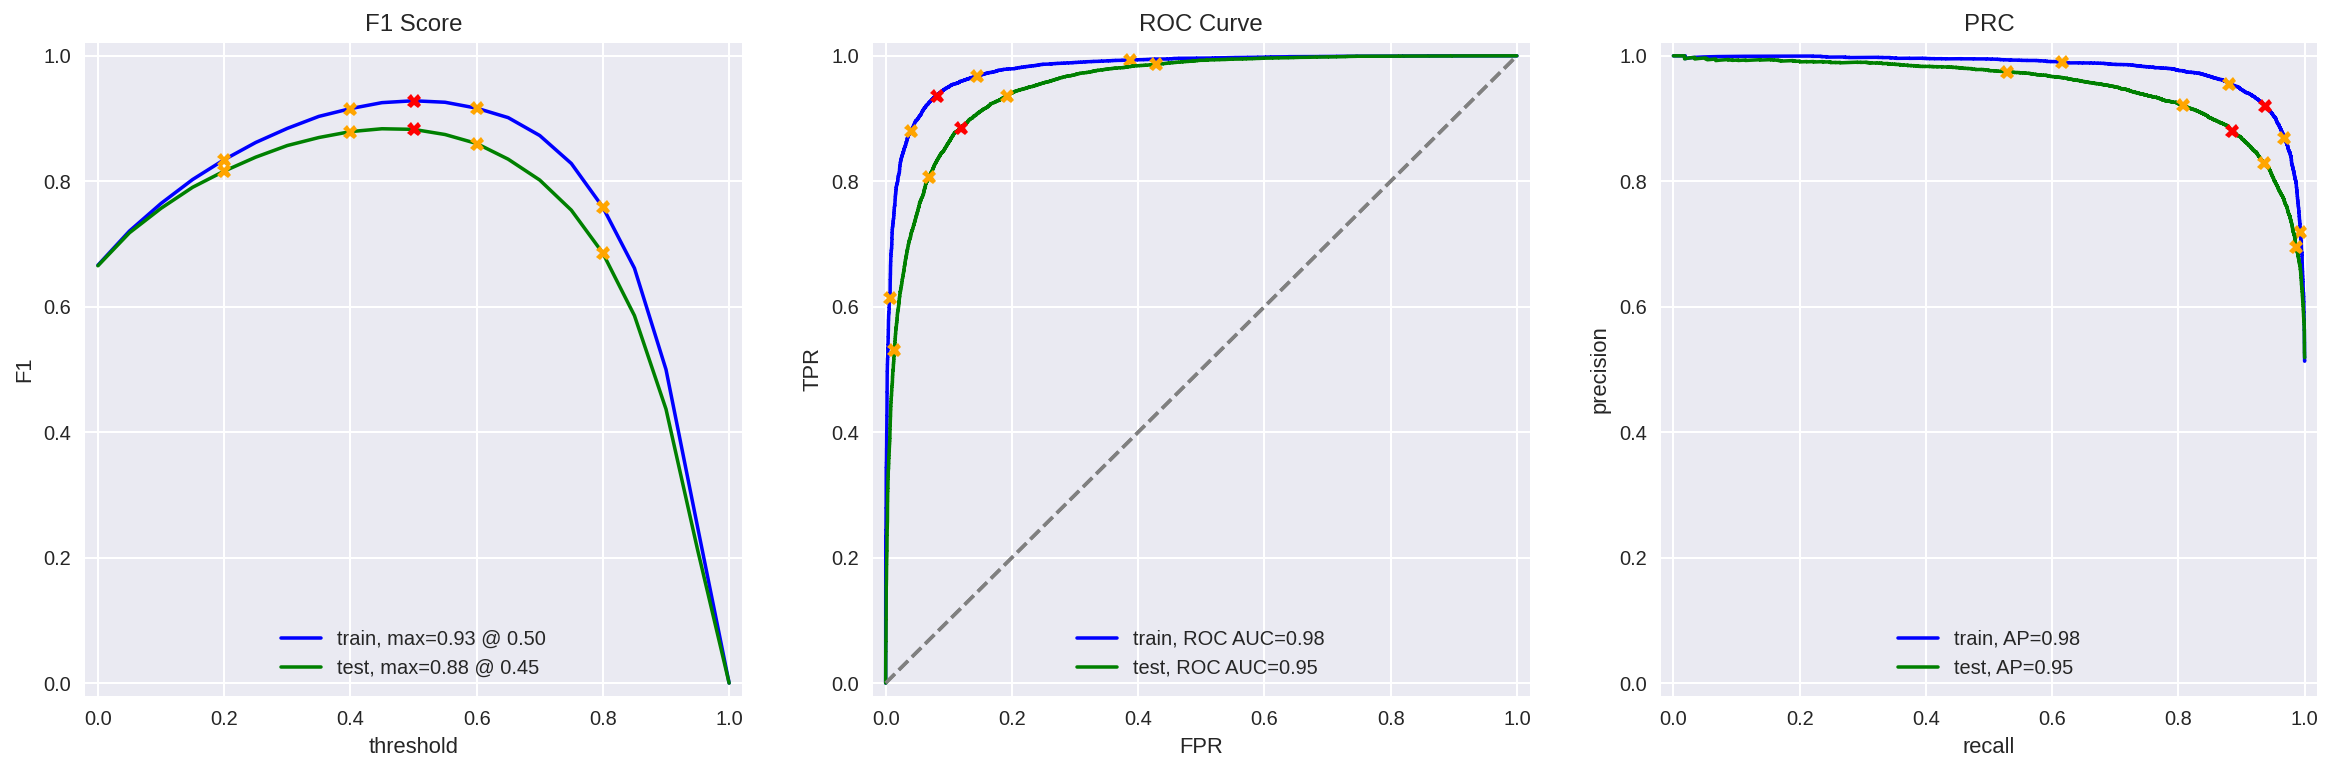

time: 3.91 s


In [ ]:
evaluate_model(lr, X_train_tfv, y_train, tfv.transform(df_reviews_test['review_norm'].values), y_test)

I believe we got better result in this case, seems that figures are closed to CountVectoriser and Naive Bayes model, but it's more well-considered result, that is not so overfitted as previous therefore numbers are more confidential

In [ ]:
kf = KFold(n_splits=5,random_state=random_state, shuffle=True)
f1_cv = cross_val_score(lr, X_train_tfv, y_train, cv=kf, scoring='f1')
f1_cv.mean()

0.8868177324120721

time: 3.5 s


### Reviews

In [ ]:
texts = pd.Series([
      'I did not simply like it, not my kind of movie.',
      'Well, I was bored and felt asleep in the middle of the movie.',
      'I was really fascinated with the movie',    
      'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
      'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
      'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
      'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
      'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'])

def show_test_proba(model, data):
    my_reviews_pred_prob = model.predict_proba(data)[:, 1]
    for i, review in enumerate(texts.str.slice(0, 100)):
      print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

time: 4.94 ms


In [ ]:
show_test_proba(lr, data=tfv.transform(clean_column(texts)).todense())

0.09:  I did not simply like it, not my kind of movie.
0.07:  Well, I was bored and felt asleep in the middle of the movie.
0.55:  I was really fascinated with the movie
0.15:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.21:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.42:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.04:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.92:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi
time: 14.9 ms


# Model 3 - spaCy, TF-IDF and LR

In [ ]:
!nvidia-smi | grep 'CUDA Version'

| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
time: 365 ms


In [ ]:
import spacy
spacy.__version__

'2.2.4'

time: 4.49 ms


In [ ]:
# python -m spacy download en_core_web_sm
# python -m spacy download en

%%capture
%%bash

pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.4/en_core_web_sm-2.2.4.tar.gz#egg=en_core_web_sm -U

time: 1.29 s


In [ ]:
spacy.prefer_gpu()

True

time: 3.38 ms


In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

time: 1.62 s


In [ ]:
def array_preprocessing_3(X):
  nlp_pipes = nlp.pipe(X, disable=["parser", "ner"], n_threads=4, batch_size=1000) 
  return np.array([' '.join(token.lemma_ for token in doc) for doc in nlp_pipes])

time: 2.26 ms


In [ ]:
def text_preprocessing_3(text):
    return ' '.join(token.lemma_ for token in nlp(text))

time: 1.02 ms


In [ ]:
X_train_tfv = array_preprocessing_3(df_reviews_train["review"].values)
tfv=TfidfVectorizer(min_df=0, max_features=10_000, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=(1,1),
                            use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english")   
X_train_tfv = tfv.fit_transform(X_train_tfv)

time: 1min 13s


In [ ]:
X_test_tfv = array_preprocessing_3(df_reviews_test["review"].values)
X_test_tfv = tfv.transform(X_test_tfv)

time: 1min 2s


,precision,recall,f1-score,support
0,0.879194,0.872490,0.875829,11803.000000
1,0.872673,0.879369,0.876008,11730.000000
accuracy,0.875919,0.875919,0.875919,0.875919
macro avg,0.875934,0.875930,0.875919,23533.000000
weighted avg,0.875944,0.875919,0.875919,23533.000000


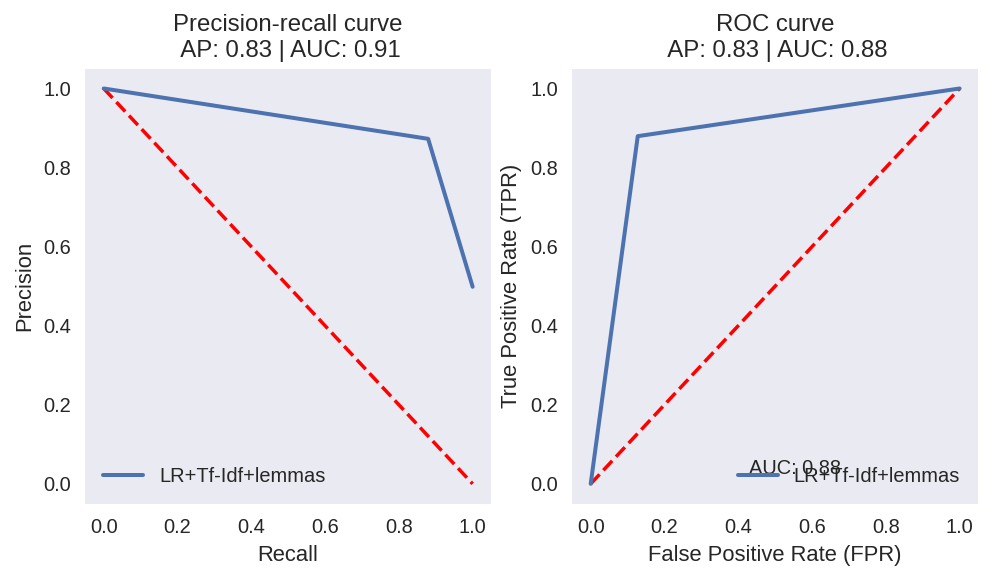

time: 1.1 s


In [ ]:
lr = LogisticRegression().fit(X_train_tfv, y_train)
y_pred = lr.predict(X_test_tfv)
display_classification_report(y_test, y_pred)
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
_ = plot_pr(y_test, y_pred, ax=ax[0],label="LR+Tf-Idf+lemmas")
_ = plot_roc(y_test, y_pred, ax=ax[1],label="LR+Tf-Idf+lemmas")

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


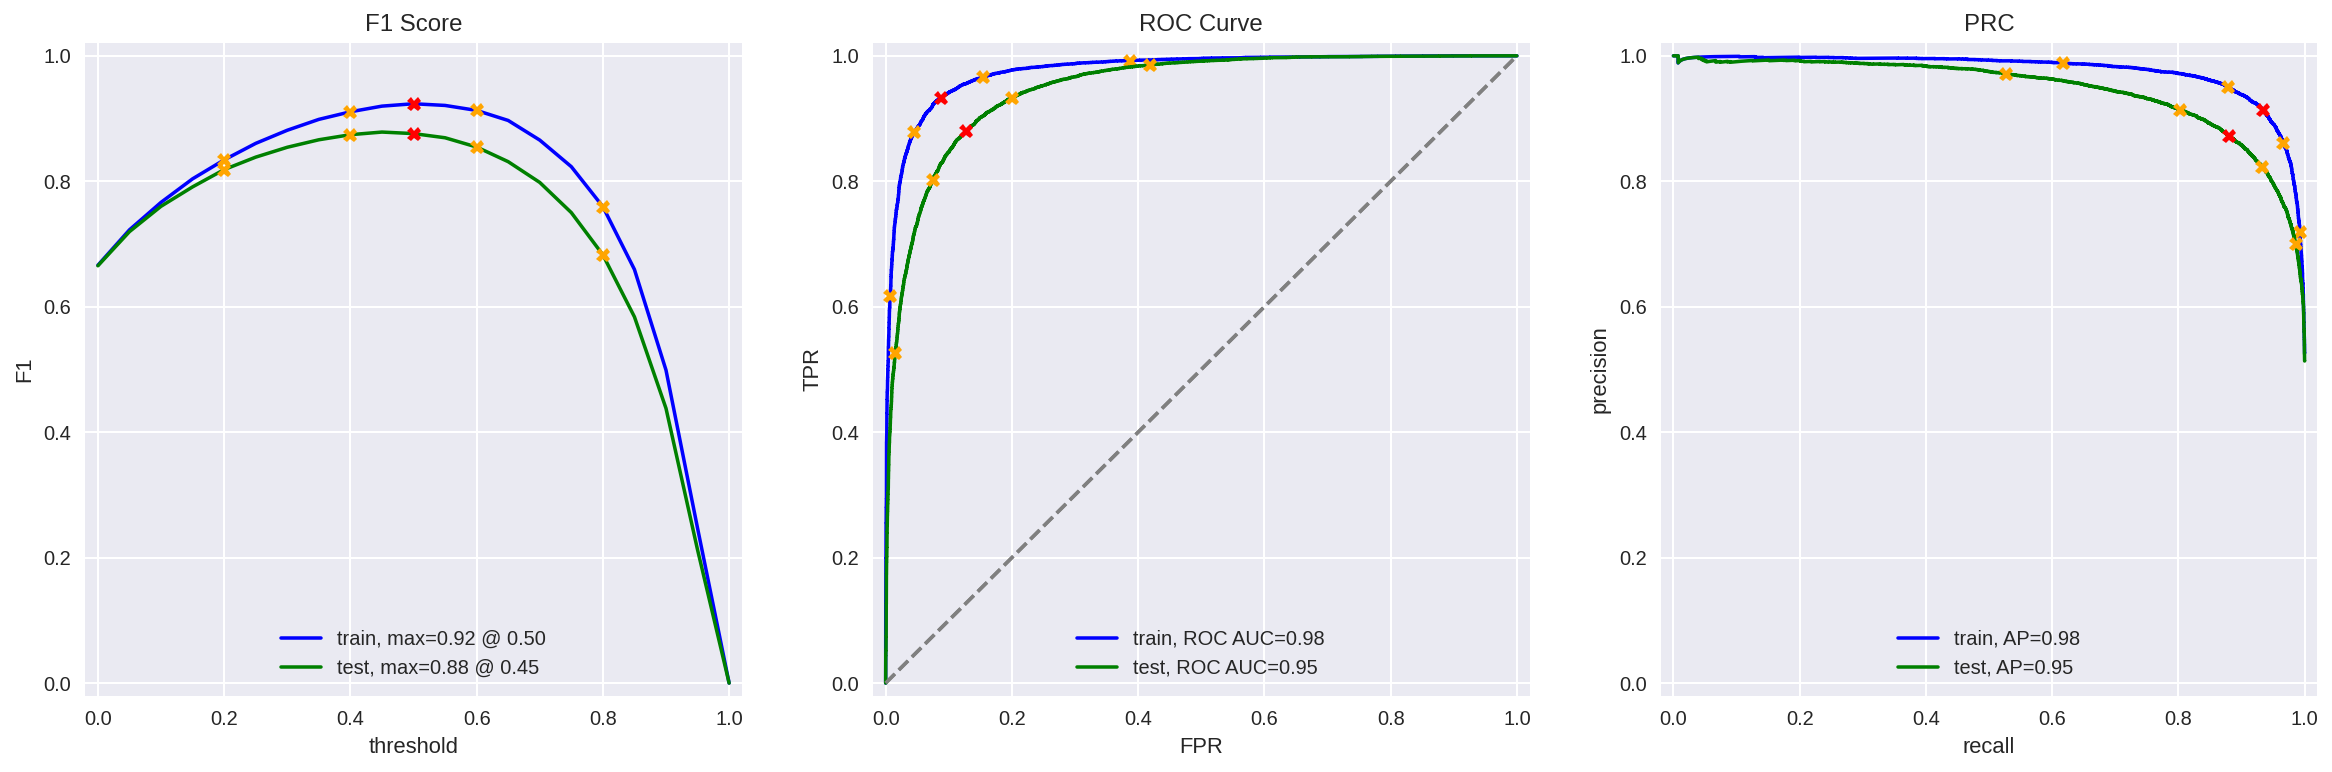

time: 1.27 s


In [ ]:
evaluate_model(lr, X_train_tfv, y_train, X_test_tfv, y_test)

### Reviews

In [ ]:
show_test_proba(lr, data=tfv.transform(np.vectorize(text_preprocessing_3)(pd.Series(clean_column(texts)))).todense())

0.24:  I did not simply like it, not my kind of movie.
0.08:  Well, I was bored and felt asleep in the middle of the movie.
0.34:  I was really fascinated with the movie
0.11:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.17:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.53:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.03:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.93:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi
time: 75.3 ms


# Model 4 - spaCy, TF-IDF and LGBMClassifier

,precision,recall,f1-score,support
0,0.862323,0.844277,0.853204,11803.00000
1,0.846539,0.864365,0.855359,11730.00000
accuracy,0.854290,0.854290,0.854290,0.85429
macro avg,0.854431,0.854321,0.854282,23533.00000
weighted avg,0.854455,0.854290,0.854278,23533.00000


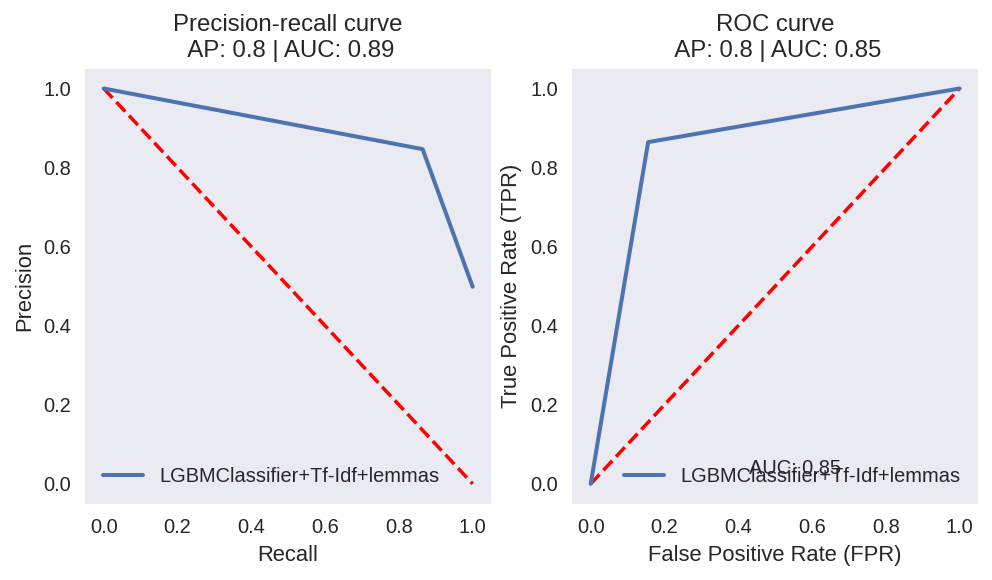

time: 26.1 s


In [ ]:
model = LGBMClassifier().fit(X_train_tfv, y_train)
y_pred = model.predict(X_test_tfv)
display_classification_report(y_test, y_pred)
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
_ = plot_pr(y_test, y_pred, ax=ax[0],label="LGBMClassifier+Tf-Idf+lemmas")
_ = plot_roc(y_test, y_pred, ax=ax[1],label="LGBMClassifier+Tf-Idf+lemmas")

          train  test
Accuracy   0.91  0.85
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


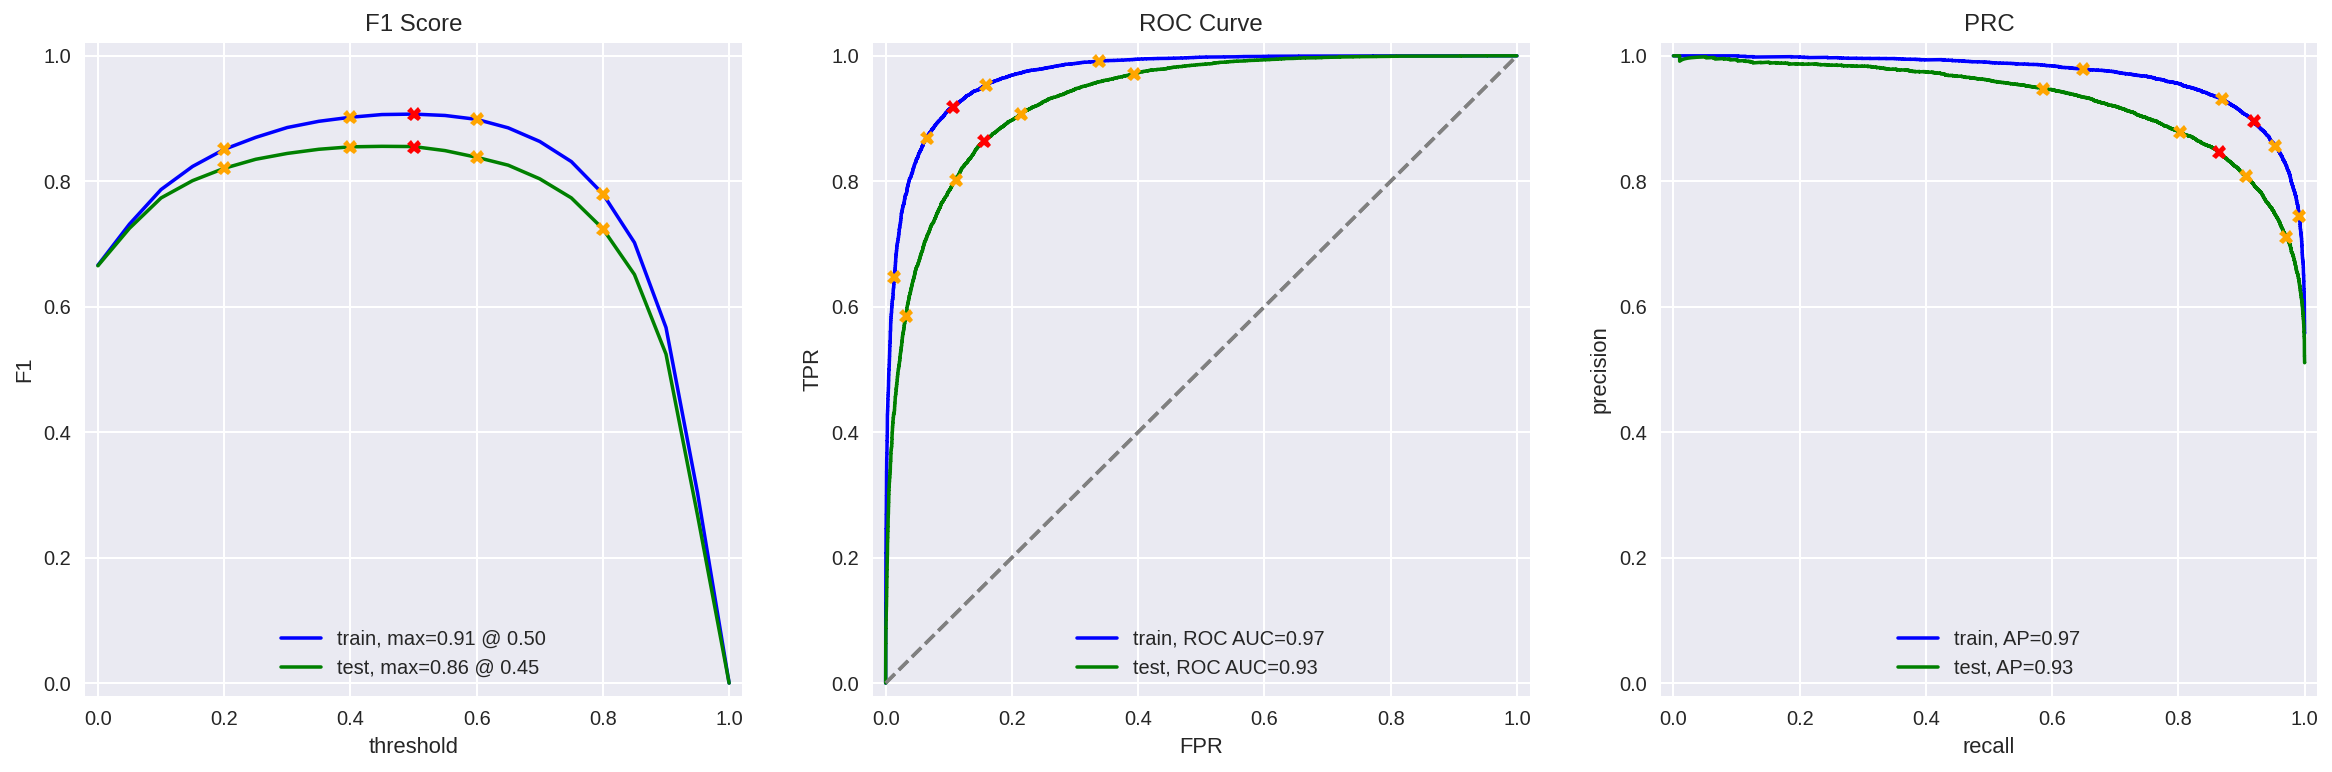

time: 1.68 s


In [ ]:
evaluate_model(model, X_train_tfv, y_train, X_test_tfv, y_test)

### Reviews

In [ ]:
show_test_proba(model, data=tfv.transform(np.vectorize(text_preprocessing_3)(pd.Series(clean_column(texts)))).todense())

0.60:  I did not simply like it, not my kind of movie.
0.41:  Well, I was bored and felt asleep in the middle of the movie.
0.63:  I was really fascinated with the movie
0.42:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.48:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.62:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.29:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.82:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi
time: 78 ms


# Model 5 RandomForestClassifier

          train  test
Accuracy   0.80  0.77
F1         0.81  0.77
APS        0.87  0.83
ROC AUC    0.88  0.84


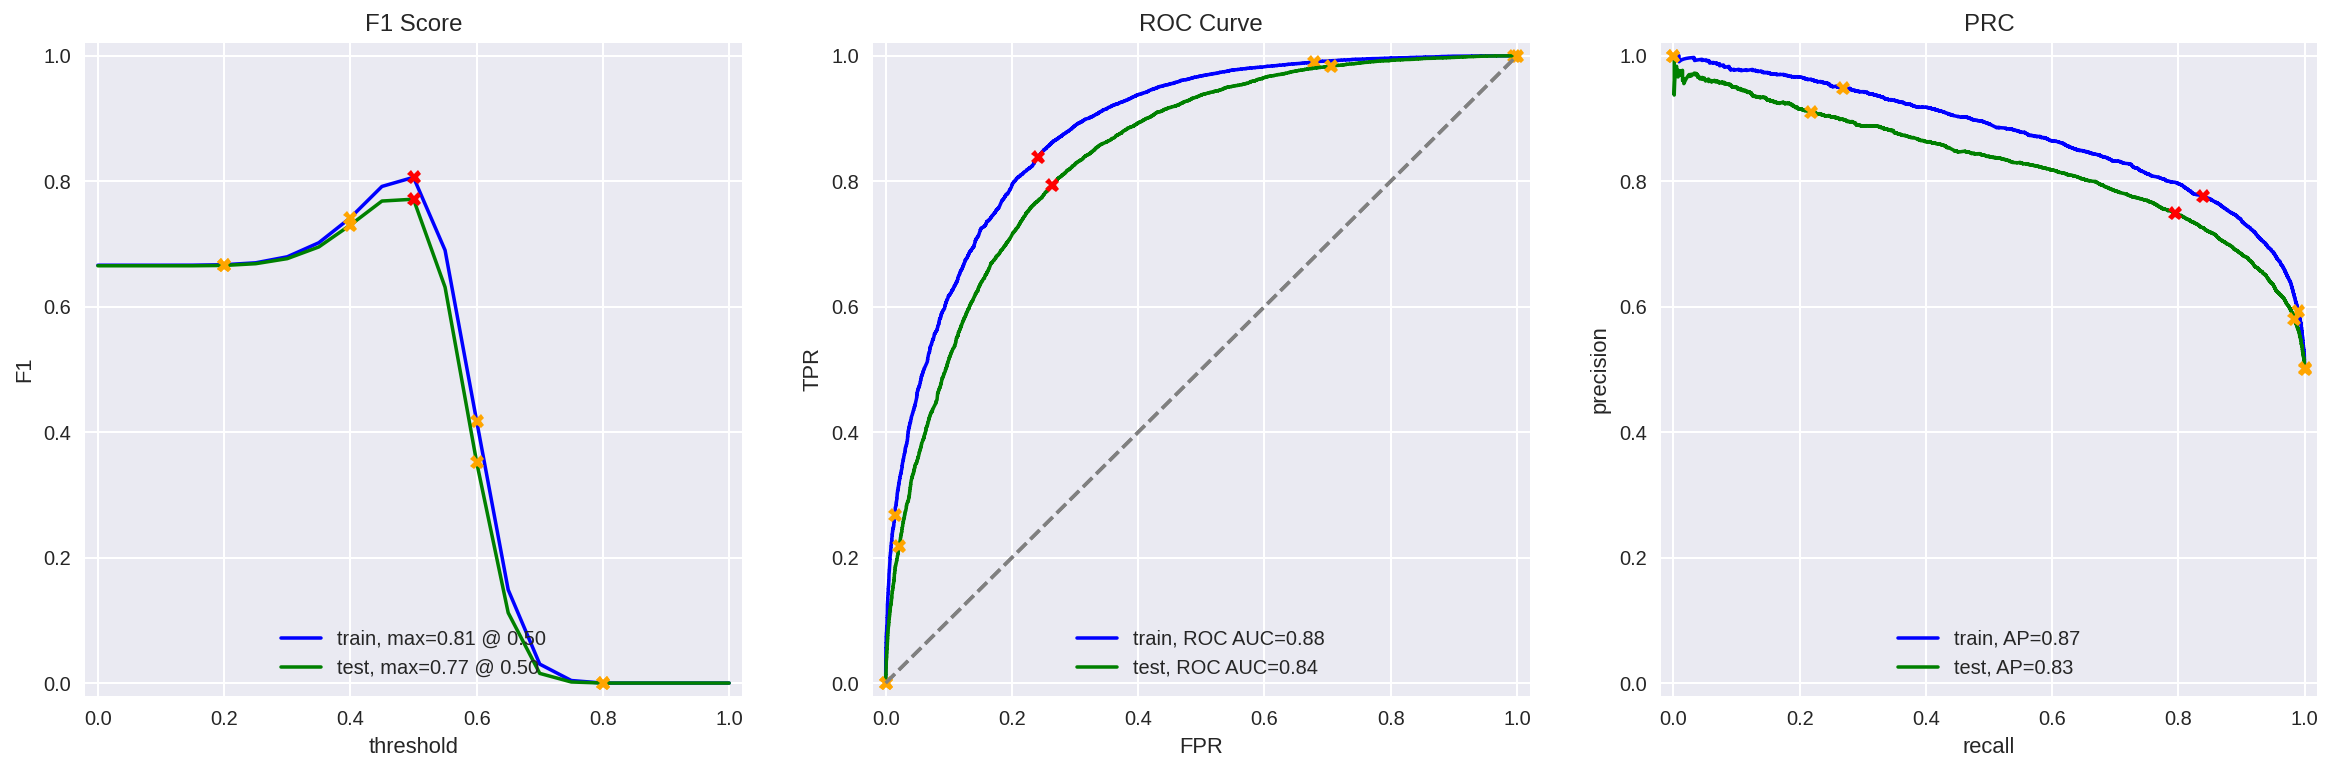

time: 1.89 s


In [ ]:
skl_model = RandomForestClassifier(n_estimators=10, max_depth=10).fit(X_train_tfv, y_train)
evaluate_model(skl_model, X_train_tfv, y_train, X_test_tfv, y_test)

by default random forest shows poor result, the key is hypertuning, cv and etc, (which is time expensive)

,precision,recall,f1-score,support
0,0.782636,0.737016,0.759141,11803.000000
1,0.750040,0.794032,0.771410,11730.000000
accuracy,0.765436,0.765436,0.765436,0.765436
macro avg,0.766338,0.765524,0.765275,23533.000000
weighted avg,0.766389,0.765436,0.765256,23533.000000


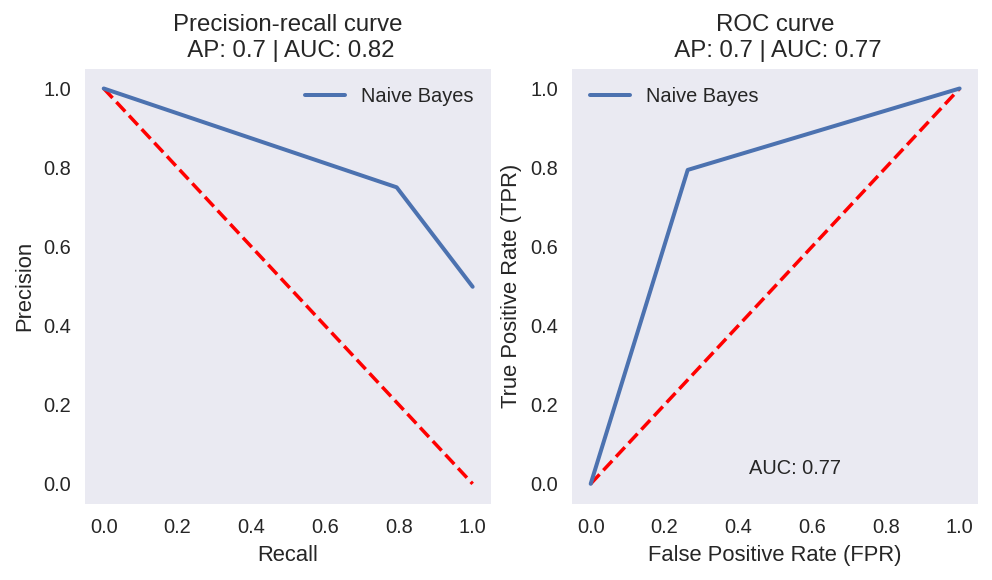

time: 540 ms


In [ ]:
y_pred = skl_model.predict(X_test_tfv)
display_classification_report(y_test, y_pred)
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
_ = plot_pr(y_test, y_pred, ax=ax[0],label="Naive Bayes")
_ = plot_roc(y_test, y_pred, ax=ax[1],label="Naive Bayes")

#  Model 9 - BERT

In [14]:
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig
torch.backends.cudnn.benchmark = True

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

time: 10 s


First of all let's check possible max length

Token indices sequence length is longer than the specified maximum sequence length for this model (2734 > 512). Running this sequence through the model will result in indexing errors


max len is: 2734


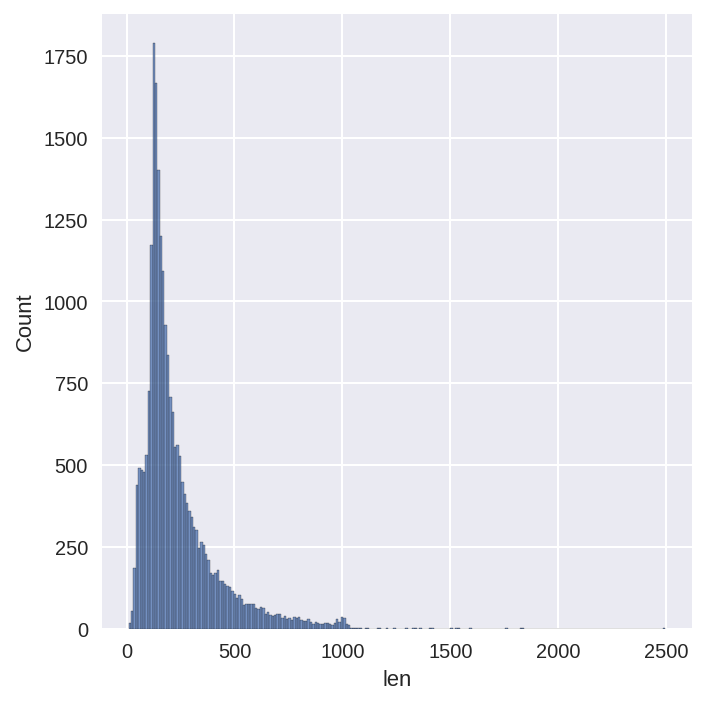

time: 1.17 s


In [ ]:
def len_tokens(s):
  return len(s.split())

df = df_reviews_train.copy()
df["len"] = np.vectorize(len_tokens)(df["review_norm"])
print("max len is: {}".format(max(list(map(len, tokenizer.batch_encode_plus(df.sort_values(by="len", ascending=False)[:1]["review_norm"].to_list())["input_ids"])))))
sns.displot(df["len"])
del df

in real case we could create embeddings by chunk 512 and pool it (meaning or by some another way) but in this case we see, that according dist of length, sentences that are greater than 512, actually are not so important. but let's think that max_length=128 in our case for fast computation (bert has O(n^2) complexity depends on length of input)

In [15]:
max_length = 128
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu_device = torch.device('cpu')
bert_path="bert-base-uncased"
batch_size=32

time: 3.14 ms


In [16]:
class TokenizersDataset(Dataset):

    def __init__(self, in_data, targets, tokenizer, max_len, splitter_func=None):
        self.data = in_data
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.splitter_func = splitter_func
        assert len(in_data)==len(targets)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        batch = [self.data[idx]]
        is_pretokenized = self.splitter_func is not None
        if is_pretokenized:
            batch = [self.splitter_func(sentence) for sentence in batch]

        encoding = self.tokenizer.encode_plus(
            batch,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            is_pretokenized=is_pretokenized,
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'target' : self.targets[idx]
        }

    @staticmethod
    def from_data(data, targets, tokenizer, max_len, batch_size=8):
        ds = TokenizersDataset(
            in_data=data,
            targets=targets,
            tokenizer=tokenizer,
            max_len=max_len,
        )
        return DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=False,
            # num_workers=2, -> on colab i have only one GPU
            # pin_memory=True
        )

time: 13.7 ms


In [17]:
train_dataloader = TokenizersDataset.from_data(df_reviews_train["review_norm"].values, df_reviews_train["pos"].values, tokenizer, max_len=max_length, batch_size=batch_size)
test_dataloader = TokenizersDataset.from_data(df_reviews_test["review_norm"].values, df_reviews_test["pos"].values, tokenizer, max_len=max_length, batch_size=batch_size)

time: 2.12 ms


In [20]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

time: 5.35 ms


In [49]:
n_examples=2
model = SentimentClassifier(n_examples)
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

time: 2.86 s


In [53]:
def accuracy(outputs, labels):
    predicted = torch.argmax(outputs, dim=1)
    return torch.mean(torch.eq(predicted, labels).float()).item()

time: 1.51 ms


In [60]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples, epoch):
      pbar = tqdm(data_loader, desc=f"Epoch {epoch + 1}. Train Loss: {0}")
      device = default_device
      model.to(device)
      model = model.train()
      loss_fn = nn.CrossEntropyLoss().to(device)
      losses = []
      correct_predictions = 0
      for step, d in enumerate(pbar):
          targets = d["target"].to(device)
          outputs = model(
            input_ids=d["input_ids"].to(device),
            attention_mask=d["attention_mask"].to(device)
          ).to(device)
          _, preds = torch.max(outputs, dim=1)
          loss = loss_fn(outputs, targets)
          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())
          loss.backward()
          nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          scheduler.step()
          optimizer.zero_grad()
          
          acc = accuracy(outputs, targets)
          pbar.set_description(f"Epoch:{epoch + 1}.Train Loss:{loss:.4} Acc:{acc:.4}")
          if step%100==0:gc.collect();torch.cuda.empty_cache();
          
          
      return correct_predictions.double() / n_examples, np.mean(losses)

time: 17.6 ms


In [ ]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(model,train_dataloader,loss_fn,optimizer,default_device,scheduler,len(df_reviews_train), epoch)
  print(f'Train loss {train_loss} accuracy {train_acc}')

Epoch 1/10
----------



Train loss 0.7280791754764254 accuracy 0.5071440578248445
Epoch 2/10
----------



Train loss 0.7173997138136177 accuracy 0.4983610690872416
Epoch 3/10
----------



Train loss 0.704873473053017 accuracy 0.5029836947386116
Epoch 4/10
----------


# Conclusions

Several models were checked and different methods: linear models, using lemmatization, a bag of words, TF-IDF, and transformers, BERT
faster and good according to F1-score was BoW models with Naive Bayes (also I think we could use instead of this model, e.g. xgboost model) 
some smart model with BERT approach didn't show some significant result, but due to some limitation of the resources I didn't check good model(was the only simple model) on it, without searching hyperparameters and others optimizations



BoW + Naive Bayes

<div class="stream"><div class="output_subarea output_text"><pre>          train  test
Accuracy   0.90  0.81
F1         0.89  0.80
APS        0.96  0.87
ROC AUC    0.96  0.89
</pre></div></div>


NLTK, TF-IDF and LR


<pre>          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
</pre>


spaCy, TF-IDF and LR


<div class="stream"><div class="output_subarea output_text"><pre>          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
</pre></div></div>


spaCy, TF-IDF and LGBMClassifier


<pre>          train  test
Accuracy   0.91  0.85
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93
</pre>

as we see best result by test and f1 score, we got using TfIdf + LR which is make sense, in this case, sentiment analysis

also was finetuned bert model, but due limitation of resources I didn't train-evaluate model properly and therefore didn't consider it on result stage

# Check List

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions